In [1]:
import tensorflow as tf
import numpy as np
import models
import matplotlib.pyplot as plt

# Settings

In [2]:
TRAIN_ID = range(3,11)         # Raw file format : Sample0001.zip - Sample0470.zip
VALIDATION_ID = range(471,481)  # Raw file format : Sample0471.zip - Sample0700.zip
TEST_ID = range(701,711)        # Raw file format : Sample0701.zip - Sample0941.zip
# TRAIN_LIST = range(1,471)         # Raw file format : Sample0001.zip - Sample0470.zip
# VALIDATION_LIST = range(471,701)  # Raw file format : Sample0471.zip - Sample0700.zip
# TEST_LIST = range(701,941)        # Raw file format : Sample0701.zip - Sample0941.zip

IMAGE_SIZE = (320, 320, 3)

In [3]:
TFRecord_DATA_PATH = './tf-data/'

In [4]:
FRAMES_PER_CLIP = 8 
MAX_FRAMES = 2000
CLIPS_PER_VIDEO = int(MAX_FRAMES / FRAMES_PER_CLIP)

'''Self-defined gesture labels'''
NO_GESTURE = 21
EMPTY_PADDING = 22

In [5]:
'''Training parameters'''
NUM_EPOCHS = 1
NUM_READ_THREADS = 1
BATCH_SIZE = 1
QUEUE_CAPACITY = BATCH_SIZE * 2

# input Pipeline

In [6]:
def preprocessing_op(image_op):
    '''most preprocess should be done while making the .tfrecords files?'''
    with tf.name_scope('preprocessing'):
        # Reshape serialized image
        image_op = tf.reshape(image_op, [FRAMES_PER_CLIP] + list(IMAGE_SIZE))
        # Integer to float
        image_op = tf.to_float(image_op)
        # Normalize (Zero-mean unit-variance) on single image
        image_op = tf.map_fn(lambda img: tf.image.per_image_standardization(img), image_op)
        
        return image_op
    
def read_and_decode(filename_queue):
    readerOptions = tf.python_io.TFRecordOptions(compression_type=tf.python_io.TFRecordCompressionType.GZIP)
    reader = tf.TFRecordReader(options=readerOptions)
    _, serialized_example = reader.read(filename_queue)
    
    with tf.name_scope('TFRecordDecoding'):
        context_encoded, features_encoded = tf.parse_single_sequence_example(
            serialized_example,
            context_features={'sample_id': tf.FixedLenFeature([], dtype=tf.int64)},
            sequence_features={'rgbs':tf.FixedLenSequenceFeature([],dtype=tf.string), # TODO: check string or bytes
                     'labels':tf.FixedLenSequenceFeature([], dtype=tf.int64)} # TODO: check string or bytes
        )
        seq_rgb = tf.decode_raw(features_encoded['rgbs'], tf.uint8)
        seq_label = features_encoded['labels']
        print(features_encoded['rgbs'])
        print(features_encoded['labels'])
        # apply preprocessing to single image using map_fn
        seq_rgb = tf.map_fn(lambda x: preprocessing_op(x), elems = seq_rgb, dtype=tf.float32, back_prop=False)
        
        return [seq_rgb, seq_label]
    

def input_pipeline(filenames, data_type):
    
    with tf.name_scope('input_pipeline'):
        # Create a input file queue
        filename_queue = tf.train.string_input_producer(filenames, num_epochs=NUM_EPOCHS, shuffle=True)
        
        # Read data from .tfreords files and decode to a list of samples (Using threads)
        samples = [read_and_decode(filename_queue) for _ in range(NUM_READ_THREADS)]
        
        # Create batches
        # batch_join is used for N threads, can use batch_join_shuffle too
        batch_rgb, batch_labels = tf.train.batch_join(samples, 
                                                      batch_size = BATCH_SIZE,
                                                      capacity = QUEUE_CAPACITY,
                                                      shapes = [[CLIPS_PER_VIDEO, FRAMES_PER_CLIP] + list(IMAGE_SIZE), [CLIPS_PER_VIDEO, ]],
                                                      enqueue_many= False, 
                                                      dynamic_pad = False, 
                                                      name = 'batch_join')
        if (data_type == 'Train' or data_type == 'Validation'):
            return batch_rgb, batch_labels
        else:
            return batch_rgb


In [7]:
def look_into_tfRecords(filenames, data_type):
    %matplotlib inline
    print(filenames)

    batch_samples_op, batch_labels_op = input_pipeline(filenames, data_type)

    sess = tf.Session()
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create threads to prefetch the data
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    batch_samples, batch_labels = sess.run([batch_samples_op, batch_labels_op])
    
    
    # Print 
    print("# Samples: " + str(len(batch_samples)))
    print("Sequence labels: " + str(batch_labels))

    # Note that the second dimension will give maximum-length in the batch, i.e., the padded sequence length.
    print("Sequence type: " + str(type(batch_samples)))
    print("Sequence shape: " + str(batch_samples.shape))

    # Fetch first clips 11th frame.
    img = batch_samples[0][50][0]
    print("Image shape: " + str(img.shape))

    plt.figure()
    plt.axis("off")
    plt.imshow(img) # Note that image may look wierd because it is normalized.


['./tf-data//Test/Sample0701.tfrecords', './tf-data//Test/Sample0702.tfrecords']
Tensor("input_pipeline/TFRecordDecoding/ParseSingleSequenceExample/ParseSingleSequenceExample:2", shape=(?,), dtype=string)
Tensor("input_pipeline/TFRecordDecoding/ParseSingleSequenceExample/ParseSingleSequenceExample:1", shape=(?,), dtype=int64)
# Samples: 1
Sequence labels: [[21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
  21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
  21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
  21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
  21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
  21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22
  22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
  22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
  22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 

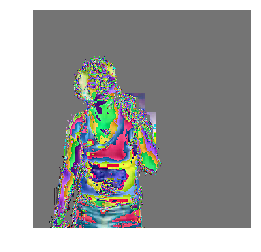

In [8]:
TRAIN_FILENAMES = ['%s/%s/Sample%04d.tfrecords' % (TFRecord_DATA_PATH, 'Train', i) for i in TRAIN_ID]
TEST_FILENAMES = ['%s/%s/Sample%04d.tfrecords' % (TFRecord_DATA_PATH, 'Test', i) for i in TEST_ID]
VALIDATION_FILENAMES = ['%s/%s/Sample%04d.tfrecords' % (TFRecord_DATA_PATH, 'Validation', i) for i in VALIDATION_ID]

look_into_tfRecords(['%s/%s/Sample%04d.tfrecords' % (TFRecord_DATA_PATH, 'Train', i) for i in range(1,2)], 'Train')
# look_into_tfRecords(['%s/%s/Sample%04d.tfrecords' % (TFRecord_DATA_PATH, 'Test', i) for i in range(701,703)], 'Train')
#look_into_tfRecords(TRAIN_FILENAMES + VALIDATION_FILENAMES, 'Train')

# Create Network

### Set up flags

In [9]:
# Model Hyperparameters
tf.flags.DEFINE_float("dropout_rate", 0.5, "Dropout rate (default: 0.5)")
# Training Parameters
tf.flags.DEFINE_integer("learning_rate", 5e-4, "Batch Size (default: 1e-3)")
tf.flags.DEFINE_integer("batch_size", 128, "Batch Size (default: 32)")
tf.flags.DEFINE_integer("num_epochs", 10000, "Number of full passess over whole training data (default: 100)")
tf.flags.DEFINE_integer("print_every_step", 200, "Print training details after this many steps/iterations (i.e., batches) (default: 10)")
tf.flags.DEFINE_integer("evaluate_every_step", 1000, "Evaluate model on validation set after this many steps/iterations (i.e., batches) (default: 500)")
tf.flags.DEFINE_integer("checkpoint_every_step", 1000, "Save model after this many steps/iterations (i.e., batches) (default: 1000)")
tf.flags.DEFINE_string("log_dir", "./runs/", "Output directory (default: './runs/')")
tf.flags.DEFINE_integer("epoch_length", int(data_split[0].shape[0]/tf.flags.FLAGS.batch_size), "Batch Size (default: 1e-3)")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nCommand-line Arguments:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")

NameError: name 'data_split' is not defined

### Create Directory for this experiment

In [ ]:
timestamp = str(int(time.time()))
FLAGS.model_dir = os.path.abspath(os.path.join(FLAGS.log_dir, timestamp))
print("Writing to {}\n".format(FLAGS.model_dir))

### set up placeholders

In [ ]:
# Feed a batch of training data at each training step using the {feed_dict} argument in sess.run()
input_samples_op = tf.placeholder(tf.float32, shape = [None, CLIPS_PER_VIDEO, FRAMES_PER_CLIP] + IMAGE_SHAPE, name='input_samples')
input_labels_op = tf.placeholder(tf.int64, shape=[None, CLIPS_PER_VIDEO, FRAME_PER_CLIP], name='input_labels')

mode = tf.placeholder(tf.bool, name='mode') # Pass True in when it is in the trainging mode
loss_avg = tf.placeholder(tf.float32, name='loss_avg')
accuracy_avg = tf.placeholder(tf.float32, name='accuracy_avg')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# pass in parameters that controls external inputs
# Returns 'logits' layer, the top-most layer of the network
logits = models.conv_model_with_layers_api(input_samples_op, FLAGS.dropout_rate, mode)


### Set up Variables

In [ ]:
# Count number of samples fed and correct predictions made.
# Attached to a summary op
counter_correct_prediction = tf.Varialbe(0, name='counter_correct_prediction', trainable=False)
counter_samples_fed = tf.Variable(0, name='counter_samples_fed', trainable=False)




# Loss calculations: cross-entropy
# TODO : Change it to CTC loss
with tf.name_scope('cross_entropy_loss'):
    #loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=input_labels_op))

# Accuracy calculations
# TODO : Try to get a serialized output
with tf.name_scope('accuracy'):
    #predictions = tf.argmax(logits, 1, name='predictions')
    #predictions = tf.Print(predictions,[predictions])
    #correct_predictions = tf.nn.in_top_k(logits, input_labels_op, 1)
    #batch_accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    #num_correct_predictions = tf.reduce_sum(tf.cast(correct_predictions, tf.int32))
    

In [ ]:
def do_evaluation(sess, samples, labels):
    

In [ ]:
TRAIN_FILENAMES = ['%s/%s/Sample%04d.tfrecords' % (TFRecord_DATA_PATH, 'Train', i) for i in TRAIN_ID]
batch_samples_op, batch_labels_op = input_pipeline(TRAIN_FILENAMES, 'Train')


In [ ]:
def do_evaluation(sess, samples, labels):
    batches = 


    def do_evaluation(sess, samples, labels):
        '''
        Evaluation function.
        @param sess: tensorflow session object.
        @param samples: input data (numpy tensor)
        @param labels: ground-truth labels (numpy array)
        '''
        batches = utils.data_iterator(samples, labels, FLAGS.batch_size)
        # Keep track of this run.
        counter_accuracy = 0.0
        counter_loss = 0.0
        counter_batches = 0
        for batch_samples, batch_labels in batches:
            counter_batches += 1
            feed_dict = {input_samples_op: batch_samples,
                         input_label_op: batch_labels,
                         mode: False}
            results = sess.run([loss, num_correct_predictions], feed_dict=feed_dict)
            counter_loss += results[0]
            counter_accuracy += results[1]
        return (counter_loss/counter_batches, counter_accuracy/(counter_batches*FLAGS.batch_size))

    # Generate a variable to contain a counter for the global training step.
    # Note that it is useful if you save/restore your network.
    global_step = tf.Variable(1, name='global_step', trainable=False)

# Training